### In this notebook we will calibrate forward model from monochromator measurements, and make a dataset. 

To calibrate, I need the dispersion from the center, the standard deviation of gaussian of each peak

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os, sys
main_dir = os.path.abspath('../../')
sys.path.insert(0, main_dir)

import models.helper as hlp
from models.custom.model import *
import forward.fourier.method as fwd
from forward.fourier.kernel_creator import create_fourier_kernel
from skimage.feature import peak_local_max
from scipy.ndimage import center_of_mass, shift
import h5py 

from torchvision.transforms import GaussianBlur


import gc
def clear_gpu():
    gc.collect()
    torch.cuda.empty_cache()

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

clear_gpu()

%load_ext autoreload
%autoreload 2

/home/s/Sunny.Howard/anaconda3/envs/torchenv/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/s/Sunny.Howard/anaconda3/envs/torchenv/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
file = h5py.File('/project/agdoepp/Howard/microlens_dataset_2.h5','r')

correlation_matrix = file['correlation_matrix'][:]

In [11]:
# Unet = UNet(n_channels=2,n_classes=10, n_levels = 3).to(device)

# class encoder_module(nn.Module):
#     def __init__(self):
#         super(encoder_module, self).__init__()
#         self.dconv1 = nn.Conv2d(10, 2, 2, stride=2)
#         self.relu1 = nn.ReLU()
#         # self.dconv2 = nn.Conv2d(2, 2, 2, stride=2)
#         # self.relu2 = nn.ReLU()
#         self.flatten = nn.Flatten()

#         self.dense1 = nn.Linear(1058, 500)
#         self.relu3 = nn.ReLU()
#         self.dense2 = nn.Linear(500, 450)

#     def forward(self, x, position):
#         x = self.dconv1(x)
#         x = self.relu1(x)
#         # x = self.dconv2(x)
#         # x = self.relu2(x)
#         x = self.flatten(x)

#         x = torch.cat((x,position),1)
#         x = self.dense1(x)
#         x = self.relu3(x)
#         x = self.dense2(x)

#         return x.reshape(-1,3,150)
    

class FCN(nn.Module):
    def __init__(self, input_size, output_size, dropout_factor = 0.5):
        super(FCN, self).__init__()

        scale = 4

        input_dropout = 0
        self.dropout0 = nn.Dropout(input_dropout)
        self.batchnorm0 = nn.BatchNorm1d(input_size)

        self.dense1 = nn.Linear(input_size, scale * 1000* int(1/(1-input_dropout)))
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_factor)
        self.batchnorm1 = nn.BatchNorm1d(scale * 1000* int(1/(1-input_dropout)))


        self.dense2 = nn.Linear(scale * 1000* int(1/(1-input_dropout)), scale * 500 * int(1/(1-dropout_factor)))
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_factor)
        self.batchnorm2 = nn.BatchNorm1d(scale * 500 * int(1/(1-dropout_factor)))


        # self.dense3 = nn.Linear(scale * 500* int(1/(1-dropout_factor)),scale *  100 * int(1/(1-dropout_factor)))
        # self.relu3 = nn.ReLU()
        # self.dropout3 = nn.Dropout(dropout_factor)
        # self.batchnorm3 = nn.BatchNorm1d(scale * 100 * int(1/(1-dropout_factor)))

        # self.dense4 = nn.Linear(scale * 100* int(1/(1-dropout_factor)),scale *  100 * int(1/(1-dropout_factor)))
        # self.relu4 = nn.ReLU()
        # self.dropout4 = nn.Dropout(dropout_factor)
        # self.batchnorm4 = nn.BatchNorm1d(scale * 100 * int(1/(1-dropout_factor)))



        self.dense4_pred = nn.Linear(scale * 500* int(1/(1-dropout_factor)), output_size[0] * output_size[1])
        self.dense4_var = nn.Linear(scale * 500* int(1/(1-dropout_factor)), output_size[0] * output_size[1])

        self.relu4 = nn.ReLU()
        self.exp = nn.Softplus()


        self.output_size = output_size

    def forward(self, x):
        # x = self.dropout0(x)
        # x = self.batchnorm0(x)
        x = self.dense1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.batchnorm1(x)
        x = self.dense2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.batchnorm2(x)

        # x = self.dense3(x)
        # x = self.relu3(x)#
        # x = self.dropout3(x)
        # x = self.batchnorm3(x)

        # x = self.dense4(x)
        # x = self.relu4(x)#
        # x = self.dropout4(x)
        # x = self.batchnorm4(x)

        pred = self.dense4_pred(x)

        var = self.dense4_var(x)
        # var = self.exp(var)
        var = torch.exp(var)

        pred, var = pred.reshape(-1,self.output_size[0],self.output_size[1]), var.reshape(-1,self.output_size[0],self.output_size[1])

        pred[:,0] = torch.sigmoid(pred[:,0])

        return pred,var
    

class mean_network(nn.Module):
    def __init__(self, input_size, output_size, dropout_factor = 0.5):
        super(mean_network, self).__init__()

        scale = 1

        input_dropout = 0
        self.dropout0 = nn.Dropout(input_dropout)
        self.batchnorm0 = nn.BatchNorm1d(input_size)

        self.dense1 = nn.Linear(input_size, scale * 1000* int(1/(1-input_dropout)))
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_factor)
        self.batchnorm1 = nn.BatchNorm1d(scale * 1000* int(1/(1-input_dropout)))


        self.dense2 = nn.Linear(scale * 1000* int(1/(1-input_dropout)), scale * 500 * int(1/(1-dropout_factor)))
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_factor)
        self.batchnorm2 = nn.BatchNorm1d(scale * 500 * int(1/(1-dropout_factor)))


        self.dense3 = nn.Linear(scale * 500* int(1/(1-dropout_factor)),scale *  100 * int(1/(1-dropout_factor)))
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout_factor)
        self.batchnorm3 = nn.BatchNorm1d(scale * 100 * int(1/(1-dropout_factor)))

        self.dense4 = nn.Linear(scale * 100* int(1/(1-dropout_factor)),scale *  100 * int(1/(1-dropout_factor)))
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(dropout_factor)
        self.batchnorm4 = nn.BatchNorm1d(scale * 100 * int(1/(1-dropout_factor)))



        self.dense4_pred = nn.Linear(scale * 100* int(1/(1-dropout_factor)), output_size[0] * output_size[1])

        self.output_size = output_size

    def forward(self, x):
        # x = self.dropout0(x)
        # x = self.batchnorm0(x)
        x = self.dense1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.batchnorm1(x)
        x = self.dense2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.batchnorm2(x)

        x = self.dense3(x)
        x = self.relu3(x)#
        x = self.dropout3(x)
        x = self.batchnorm3(x)

        x = self.dense4(x)
        x = self.relu4(x)#
        x = self.dropout4(x)
        x = self.batchnorm4(x)

        pred = self.dense4_pred(x)


        pred = pred.reshape(-1,self.output_size[0],self.output_size[1])

        pred[:,0] = torch.sigmoid(pred[:,0])

        return pred
    

# encoder = encoder_module().to(device)


In [5]:
i = [40,59]

# def extract_data(file, indices, device = device):
#     m1 = file['m1'][indices]
#     f = file['f'][indices]
#     p1 = file['p1'][indices]
#     f_peak_locs = file['f_peak_locs'][indices]
#     intensity = file['intensity'][indices]
#     phase_x = file['phase_x'][indices]
#     phase_y = file['phase_y'][indices]
#     x_data = torch.tensor(np.stack([m1,p1],axis=1)).float().to(device)
#     position = torch.tensor(f_peak_locs).float().to(device)

#     y_data = torch.tensor(np.stack([intensity,phase_x,phase_y],axis=1)).float().to(device)

#     return x_data, position, y_data

def extract_data(file, indices):
    m1 = torch.tensor(file['m1'][indices]) 
    f = torch.tensor(file['f'][indices])
    p1 = torch.tensor(file['p1'][indices])
    f_peak_locs = torch.tensor(file['f_peak_locs'][indices])
    intensity = torch.tensor(file['intensity'][indices])
    phase_x = torch.tensor(file['phase_x'][indices])
    phase_y = torch.tensor(file['phase_y'][indices])

    f_peak_locs = (f_peak_locs - torch.tensor([0, 900])[None]) / (torch.tensor([700, 1600]) - torch.tensor([0, 1000]))[None]

    return m1, p1, f, f_peak_locs, intensity, phase_x, phase_y

def collate_data(m1, p1, f, f_peak_locs, intensity, phase_x, phase_y, device = device):

    # x_data = torch.concat((m1.reshape(len(m1),-1), p1.reshape(len(m1),-1), f.reshape(len(m1),-1), f_peak_locs), dim = 1).float().to(device)
    x_data = torch.concat((m1.reshape(len(m1),-1), p1.reshape(len(m1),-1), f.reshape(len(m1),-1)), dim = 1).float().to(device)

    y_data = torch.tensor(np.stack([intensity,phase_x,phase_y],axis=1)).float().to(device)

    return x_data, y_data

x_data, y_data = collate_data(*extract_data(file, i))

# model = FCN(x_data.shape[1], y_data.shape[1:], dropout_factor=0.5).to(device)
model = mean_network(x_data.shape[1], y_data.shape[1:], dropout_factor=0.).to(device)

pred = model(x_data)

pred.shape,  y_data.shape

(torch.Size([2, 3, 33]), torch.Size([2, 3, 33]))

In [12]:
x_data.shape

torch.Size([2, 4775])

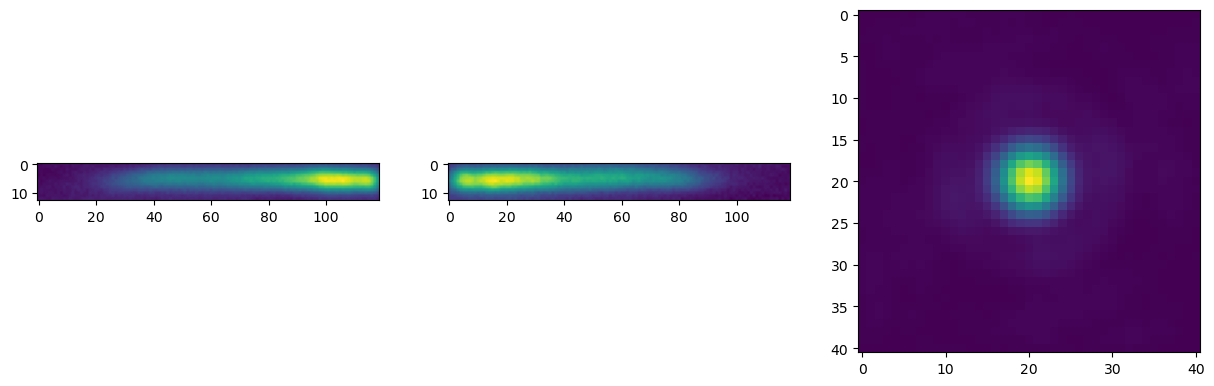

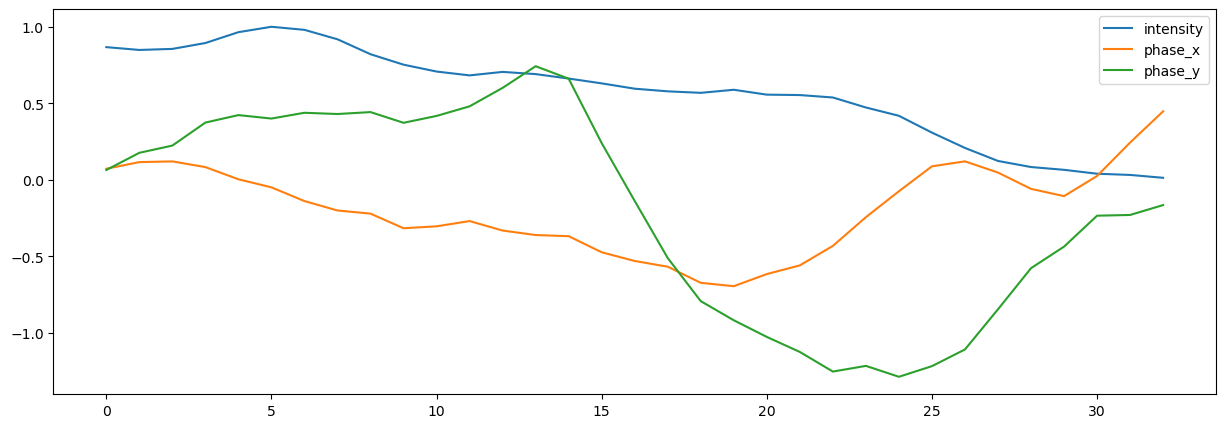

In [13]:
i = [torch.randint(0,100,(1,)).item()]

m1, p1, f, f_peak_locs, intensity, phase_x, phase_y = extract_data(file, i)

fig,ax = plt.subplots(1,3,figsize = (15,5))
ax[0].imshow(m1[0].cpu())
ax[1].imshow(p1[0].cpu())
ax[2].imshow(f[0].cpu())

fig = plt.figure(figsize = (15,5))
plt.plot(intensity[0].cpu(),label = 'intensity')
plt.plot(phase_x[0].cpu(),label = 'phase_x')
plt.plot(phase_y[0].cpu(),label = 'phase_y')
plt.legend()






In [14]:
data_samples = len(file['m1'])

bs = 64

train_samples = torch.arange(int(data_samples*0.8))
val_samples = torch.arange(int(data_samples*0.8),int(data_samples*0.9))
test_samples = torch.arange(int(data_samples*0.9),data_samples)

train_samples = train_samples[torch.randperm(len(train_samples))]
val_samples = val_samples[torch.randperm(len(val_samples))]
test_samples = test_samples[torch.randperm(len(test_samples))]

train_batches = torch.split(train_samples,bs)
val_batches = torch.split(val_samples,bs)
test_batches = torch.split(test_samples,bs)
history = {'train_loss':[],'val_loss':[], 'val_mean_loss':[]}


## Optionally can train directly on NLL using beta loss if ya like

In [15]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

beta = torch.tensor(0.5)

variance_model = FCN(x_data.shape[1], y_data.shape[1:], dropout_factor=0.).to(device)
trainable_params = list(variance_model.parameters()) 

init_lr = 1e-4


optimizer = torch.optim.Adam(trainable_params, lr=init_lr)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor = .3, patience = 7, verbose = True)

loss_fn = torch.nn.MSELoss(reduction='none')
abs_loss = torch.nn.L1Loss(reduction='none')

# history = {'train_loss':[],'val_loss':[], 'val_error_loss':[]}


epochs = 209




In [16]:


for epoch in range( epochs):
    torch.cuda.empty_cache()

    # if epoch == 50:
    #     for g in optimizer.param_groups:
    #         g['lr'] = init_lr * 1e-1


    # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
    start_time_sec = time.time()

    accum_loss = 0
    variance_model.train()
    for batch in train_batches:
        
        x_data_train, y_data_train = collate_data(*extract_data(file, torch.sort(batch)[0].tolist()))

        optimizer.zero_grad()
        pred,var = variance_model(x_data_train)
        
        # loss = torch.mean(loss_fn(pred, y_data_train))
        
        loss = torch.mean(   var.detach()**beta * (torch.log(var) +  loss_fn(pred, y_data_train) /var) ) #* 1e-2
        # else: loss = torch.mean(loss_fn(pred, y_data_train))


        
        loss.backward()
        
        optimizer.step()
        accum_loss += loss.data.item()
    
    optimizer.zero_grad()

    accum_val_loss = 0
    accum_val_mean_loss = 0

    variance_model.eval()
    for batch in val_batches:
        x_data_val, y_data_val = collate_data(*extract_data(file, torch.sort(batch)[0].tolist()))
        yhat_val, yhatvar = variance_model(x_data_val)
        loss = torch.mean( yhatvar.detach()**beta *( torch.log(yhatvar) +   loss_fn(yhat_val, y_data_val) /yhatvar))# torch.mean(loss_fn(yhat_val, y_data_val))
        mean_loss = torch.mean(loss_fn(yhat_val, y_data_val))
        accum_val_loss += loss.data.item()
        accum_val_mean_loss += mean_loss.data.item()

    train_loss = accum_loss/len(train_batches)
    val_loss = accum_val_loss/len(val_batches)
    val_mean_loss = accum_val_mean_loss/len(val_batches)

    scheduler.step(val_mean_loss)

    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec
    print(f'Epoch {epoch}/{epochs}:, train loss: {train_loss:5.5g}, val loss: {val_loss:5.5g}, val_mean_loss: {val_mean_loss:5.5g}, epoch time: {total_time_sec:5.5g}',end='\r')



    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_mean_loss'].append(val_mean_loss)

Epoch 00069: reducing learning rate of group 0 to 3.0000e-05.mean_loss: 0.020524, epoch time: 4.6486


### Train the model on the Mean first

In [129]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

trainable_params = list(model.parameters()) 

init_lr = 1e-4


optimizer = torch.optim.Adam(trainable_params, lr=init_lr)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor = .3, patience = 7, verbose = True)

loss_fn = torch.nn.MSELoss(reduction='none')
abs_loss = torch.nn.L1Loss(reduction='none')

# history = {'train_loss':[],'val_loss':[], 'val_error_loss':[]}


epochs = 209



In [130]:
for epoch in range( epochs):
    torch.cuda.empty_cache()

    # if epoch == 50:
    #     for g in optimizer.param_groups:
    #         g['lr'] = init_lr * 1e-1


    # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
    start_time_sec = time.time()

    accum_loss = 0
    model.train()
    for batch in train_batches:
        
        x_data_train, y_data_train = collate_data(*extract_data(file, torch.sort(batch)[0].tolist()))

        optimizer.zero_grad()
        pred = model(x_data_train)
        
        loss = torch.mean(loss_fn(pred, y_data_train))

        loss.backward()
        
        optimizer.step()
        accum_loss += loss.data.item()
    
    optimizer.zero_grad()

    accum_val_mean_loss = 0

    model.eval()
    for batch in val_batches:
        x_data_val, y_data_val = collate_data(*extract_data(file, torch.sort(batch)[0].tolist()))
        yhat_val = model(x_data_val)
        mean_loss = torch.mean(loss_fn(yhat_val, y_data_val))
        accum_val_mean_loss += mean_loss.data.item()

    train_loss = accum_loss/len(train_batches)
    val_mean_loss = accum_val_mean_loss/len(val_batches)

    scheduler.step(val_mean_loss)

    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec
    print(f'Epoch {epoch}/{epochs}:, train loss: {train_loss:5.5g},  val_mean_loss: {val_mean_loss:5.5g}, epoch time: {total_time_sec:5.5g}',end='\r')



    history['train_loss'].append(train_loss)
    history['val_mean_loss'].append(val_mean_loss)

Epoch 00034: reducing learning rate of group 0 to 3.0000e-05., epoch time: 3.1927
Epoch 00043: reducing learning rate of group 0 to 9.0000e-06., epoch time: 3.2106


KeyboardInterrupt: 

tensor(0.0171, device='cuda:3', grad_fn=<MeanBackward0>)


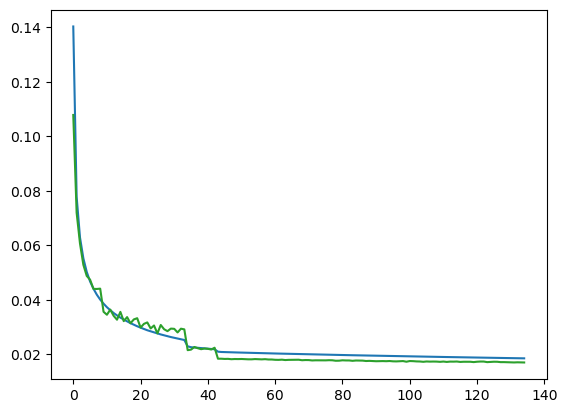

In [137]:
pred = model(x_data_val)
print(loss_fn(pred, y_data_val).mean())

plt.plot((history['train_loss']))
plt.plot((history['val_loss']))
plt.plot((history['val_mean_loss']))

### Now copy the weights over to bigger model to also do variance

In [138]:
variance_model = FCN(x_data.shape[1], y_data.shape[1:], dropout_factor=0).to(device)

for module in variance_model.modules():
    if not isinstance(module, nn.BatchNorm1d):
        for param in module.parameters():
            param.data.fill_(0)

mean_linears = [m for m in model.modules() if isinstance(m, nn.Linear)]
var_linears = [m for m in variance_model.modules() if isinstance(m, nn.Linear)]

for i in range(len(mean_linears)):

    mean_model_size = mean_linears[i].weight.data.shape
    var_linears[i].weight.data[:mean_model_size[0],:mean_model_size[1]] = mean_linears[i].weight.data.clone()
    var_linears[i].bias.data[:mean_model_size[0]] = mean_linears[i].bias.data.clone()

mean_batch_norms = [m for m in model.modules() if isinstance(m, nn.BatchNorm1d)]
var_batch_norms = [m for m in variance_model.modules() if isinstance(m, nn.BatchNorm1d)]

for i in range(len(mean_batch_norms)):

    mean_model_size = mean_batch_norms[i].weight.data.shape
    var_batch_norms[i].weight.data[:mean_model_size[0]] = mean_batch_norms[i].weight.data.clone()
    var_batch_norms[i].bias.data[:mean_model_size[0]] = mean_batch_norms[i].bias.data.clone()

mean, var = variance_model(x_data_val)
print(loss_fn(mean,y_data_val).mean())

tensor(0.0295, device='cuda:3', grad_fn=<MeanBackward0>)


In [139]:
trainable_params = list(variance_model.parameters()) 

init_lr = 1e-4


optimizer = torch.optim.Adam(trainable_params, lr=init_lr)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor = .3, patience = 7, verbose = True)


history = {'train_loss':[],'val_loss':[], 'val_mean_loss':[]}


epochs = 209

In [140]:
for epoch in range( epochs):
    torch.cuda.empty_cache()

    # if epoch == 50:
    #     for g in optimizer.param_groups:
    #         g['lr'] = init_lr * 1e-1


    # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
    start_time_sec = time.time()

    accum_loss = 0
    variance_model.train()
    for batch in train_batches:
        
        x_data_train, y_data_train = collate_data(*extract_data(file, torch.sort(batch)[0].tolist()))

        optimizer.zero_grad()
        pred,var = variance_model(x_data_train)
        
        # loss = torch.mean(loss_fn(pred, y_data_train))
        
        loss = torch.mean( torch.log(var) +  loss_fn(pred, y_data_train) /var) #* 1e-2
        # else: loss = torch.mean(loss_fn(pred, y_data_train))


        
        loss.backward()
        
        optimizer.step()
        accum_loss += loss.data.item()
    
    optimizer.zero_grad()

    accum_val_loss = 0
    accum_val_mean_loss = 0

    variance_model.eval()
    for batch in val_batches:
        x_data_val, y_data_val = collate_data(*extract_data(file, torch.sort(batch)[0].tolist()))
        yhat_val, yhatvar = variance_model(x_data_val)
        loss = torch.mean( 1/2 * torch.log(yhatvar) + 1/2 *   loss_fn(yhat_val, y_data_val) /yhatvar)# torch.mean(loss_fn(yhat_val, y_data_val))
        mean_loss = torch.mean(loss_fn(yhat_val, y_data_val))
        accum_val_loss += loss.data.item()
        accum_val_mean_loss += mean_loss.data.item()

    train_loss = accum_loss/len(train_batches)
    val_loss = accum_val_loss/len(val_batches)
    val_mean_loss = accum_val_mean_loss/len(val_batches)

    scheduler.step(val_mean_loss)

    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec
    print(f'Epoch {epoch}/{epochs}:, train loss: {train_loss:5.5g}, val loss: {val_loss:5.5g}, val_mean_loss: {val_mean_loss:5.5g}, epoch time: {total_time_sec:5.5g}',end='\r')



    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_mean_loss'].append(val_mean_loss)

Epoch 00026: reducing learning rate of group 0 to 3.0000e-05.n_loss: 0.024208, epoch time: 3.647992
Epoch 00051: reducing learning rate of group 0 to 9.0000e-06.an_loss: 0.017694, epoch time: 3.8027
Epoch 00068: reducing learning rate of group 0 to 2.7000e-06.an_loss: 0.016235, epoch time: 4.5989
Epoch 00078: reducing learning rate of group 0 to 8.1000e-07.n_loss: 0.015879, epoch time: 4.02547
Epoch 00097: reducing learning rate of group 0 to 2.4300e-07.n_loss: 0.015818, epoch time: 4.25716
Epoch 00107: reducing learning rate of group 0 to 7.2900e-08.ean_loss: 0.015805, epoch time: 3.6866


KeyboardInterrupt: 

### Uncertainty Quantification

0.519198 0.104987316


Text(0.5, 1.0, 'phase y')

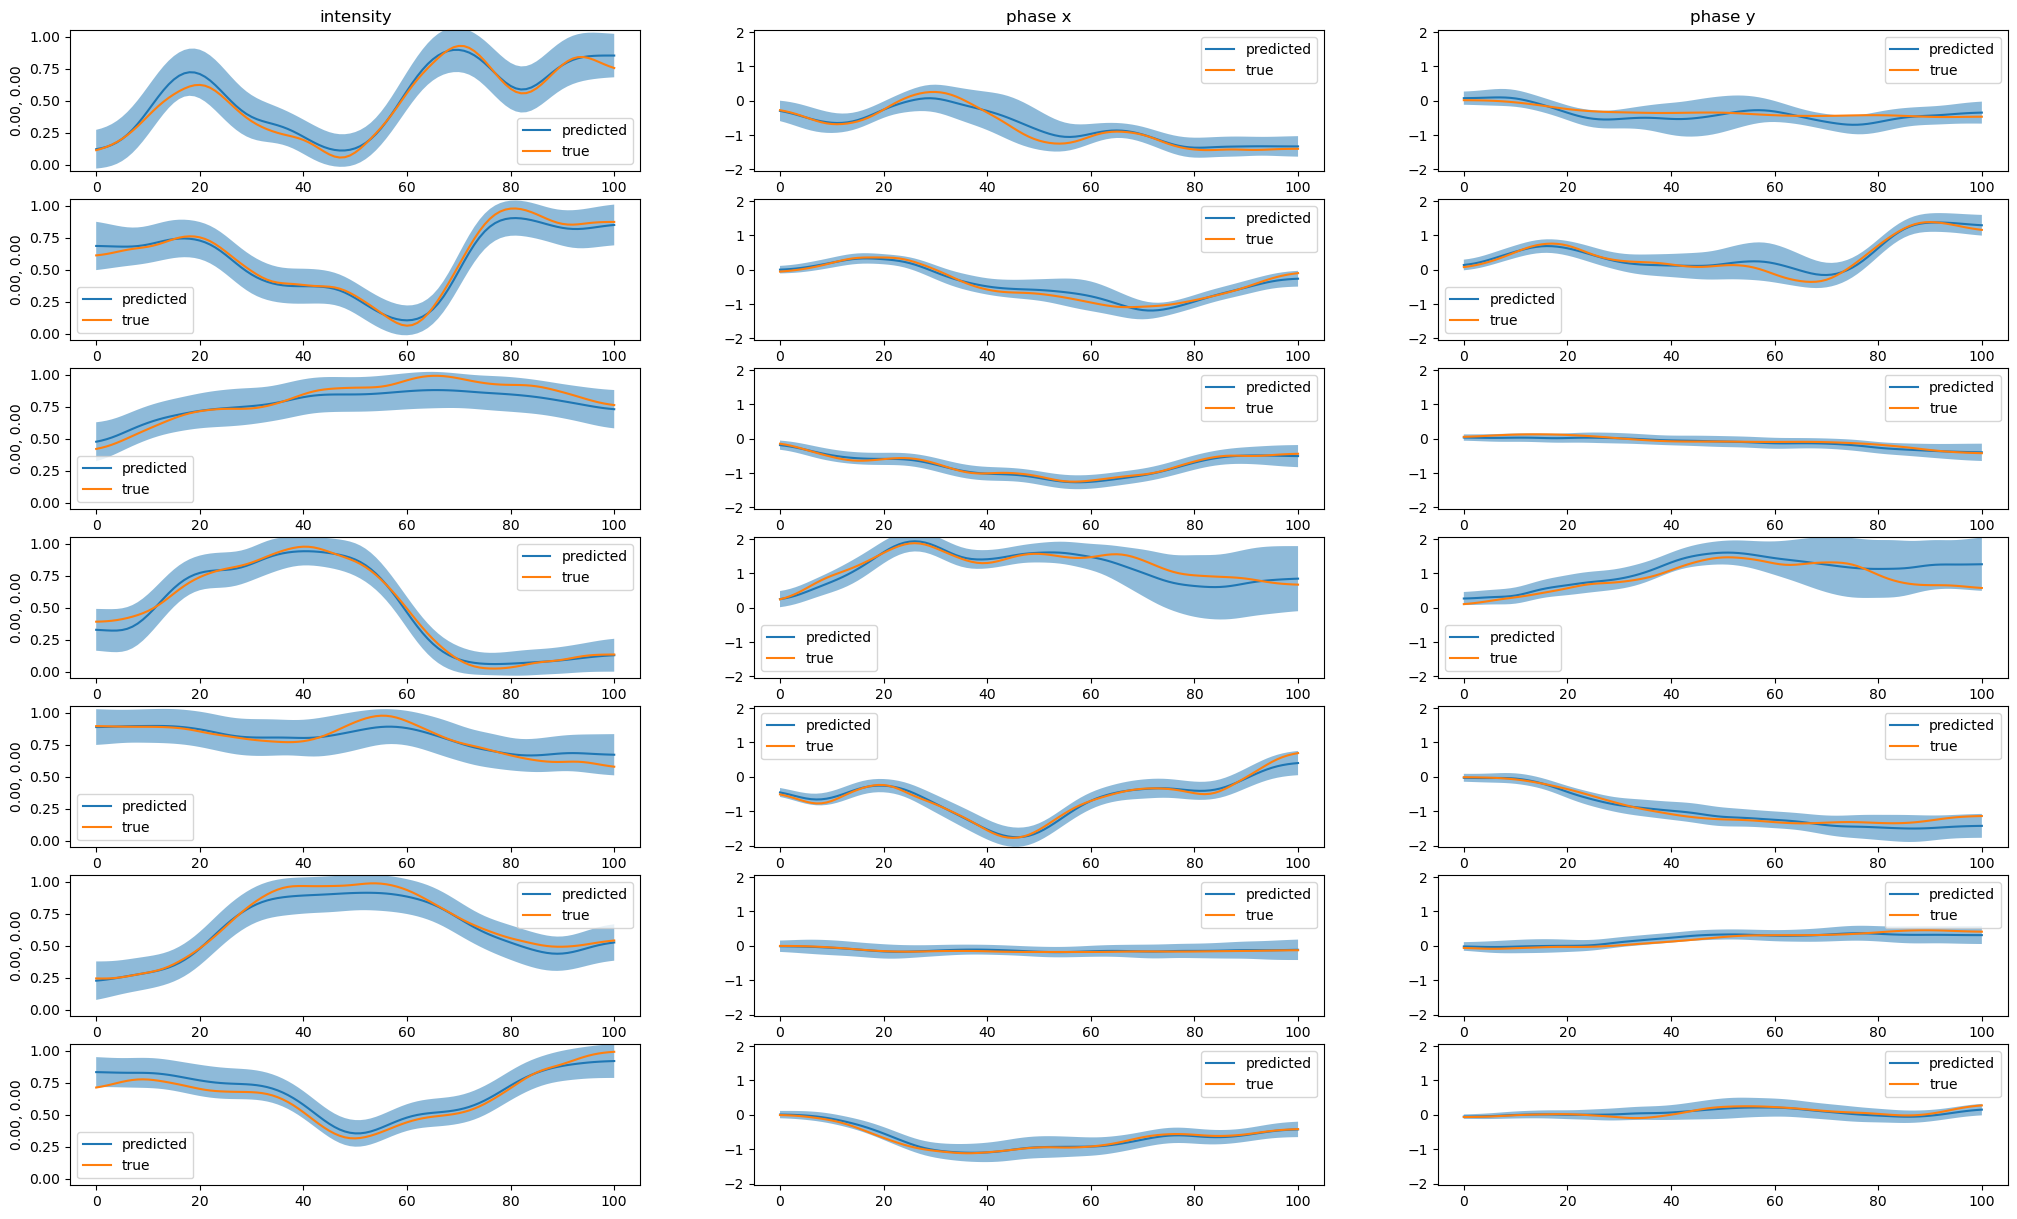

In [20]:
variance_model.eval()

batch_i = np.random.randint(0,len(test_batches))



x_data_test, y_data_test = collate_data(*extract_data(file, torch.sort(test_batches[batch_i])[0].tolist()))

y_data_test = np.einsum('ijk,lk->ijl',y_data_test.cpu().detach().numpy(),correlation_matrix)


expected, variance = variance_model(x_data_test)

expected = expected.cpu().detach().numpy()
variance = variance.cpu().detach().numpy() 

expected = np.einsum('ijk,lk->ijl',expected,correlation_matrix)
variance = np.einsum('ijk,lk->ijl',variance,correlation_matrix)

std = np.sqrt(variance)

print(std.max(), std.mean())

no_sigma = 2

fig,ax = plt.subplots(7 ,3, figsize = (25,15))

for i in range(7):
    ax[i,0].set_ylabel(f'{x_data_test[i,-2]:.2f}, {x_data_test[i,-1]:.2f}')

    ax[i,0].plot(expected[i,0],label='predicted')
    ax[i,0].fill_between(np.arange(len(expected[0,0])), expected[i,0]-std[i,0]  * no_sigma, expected[i,0]+std[i,0] * no_sigma, alpha = 0.5)
    ax[i,0].plot(y_data_test[i,0],label='true')
    ax[i,0].legend()
    ax[i,0].set_ylim(-.05,1.05)

    ax[i,1].plot(expected[i,1],label='predicted')
    ax[i,1].fill_between(np.arange(len(expected[0,1])), expected[i,1]-std[i,1] * no_sigma , expected[i,1]+std[i,1] * no_sigma, alpha = 0.5)
    ax[i,1].plot(y_data_test[i,1],label='true')
    ax[i,1].legend()
    ax[i,1].set_ylim(-2.05,2.05)


    ax[i,2].plot(expected[i,2],label='predicted')
    ax[i,2].fill_between(np.arange(len(expected[0,2])), expected[i,2]-std[i,2]  * no_sigma, expected[i,2]+std[i,2] * no_sigma, alpha = 0.5)
    ax[i,2].plot(y_data_test[i,2],label='true')
    ax[i,2].legend()
    ax[i,2].set_ylim(-2.05,2.05)


ax[0,0].set_title('intensity'); ax[0,1].set_title('phase x'); ax[0,2].set_title('phase y')


percentage of samples within 1 std: 0.8465346534653465
percentage of samples within 2 std: 0.9961324257425742
percentage of samples within 1 std: 0.8881497524752475
percentage of samples within 2 std: 0.994894801980198
percentage of samples within 1 std: 0.7702660891089109
percentage of samples within 2 std: 0.974009900990099


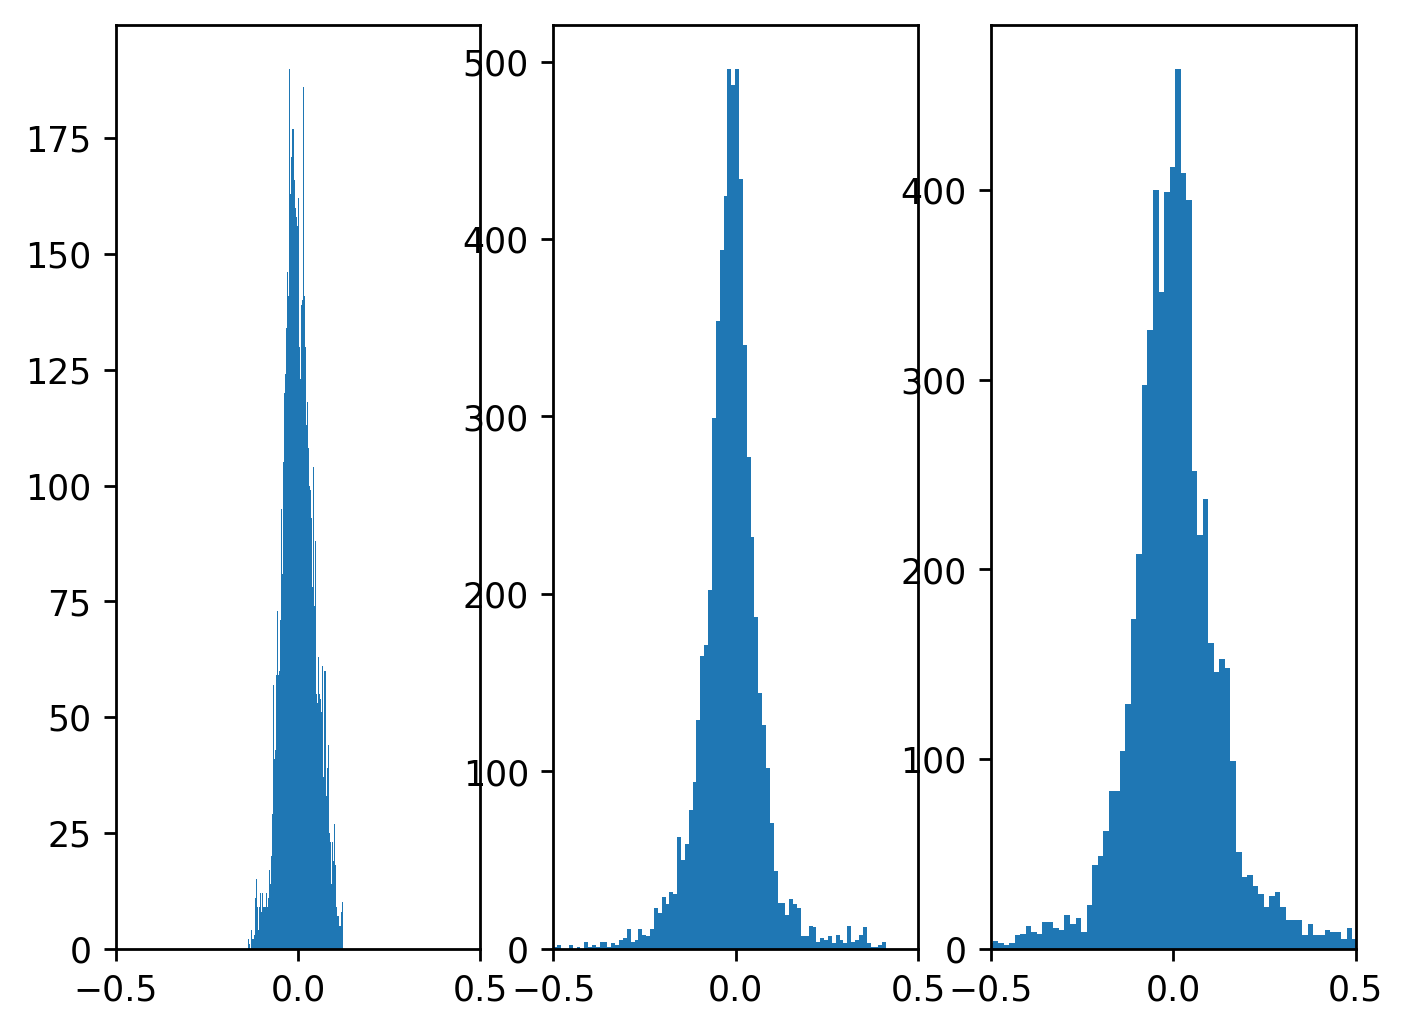

In [21]:
fig,ax = plt.subplots(1,3,dpi=250)
for i in range(3):

    ax[i].hist((y_data_test - expected)[:,i].flatten(),bins = 100, label = 'intensity')

    ax[i].set_xlim(-0.5,0.5)

    errors = np.abs(y_data_test - expected)[:,i].flatten()
    

    onestd = errors < std[:,i].flatten()
    twostd = errors < 2*std[:,i].flatten()

    print(f'percentage of samples within 1 std: {np.sum(onestd)/len(onestd)}')
    print(f'percentage of samples within 2 std: {np.sum(twostd)/len(twostd)}')

### Test on real data

In [25]:
m1 = torch.tensor(file['m1_real'][:]) 
f = torch.tensor(file['f_real'][:])
p1 = torch.tensor(file['p1_real'][:])
f_peak_locs = torch.tensor(file['f_peak_locs_real'][:])
intensity = torch.tensor(file['intensity_real'][:])
phase_x = torch.tensor(file['phase_x_real'][:])
phase_y = torch.tensor(file['phase_y_real'][:])

f_peak_locs = (f_peak_locs - torch.tensor([0, 900])[None]) / (torch.tensor([700, 1600]) - torch.tensor([0, 1000]))[None]


x_real_data, y_real_data = collate_data(m1, p1, f, f_peak_locs, intensity, phase_x, phase_y, device = device)

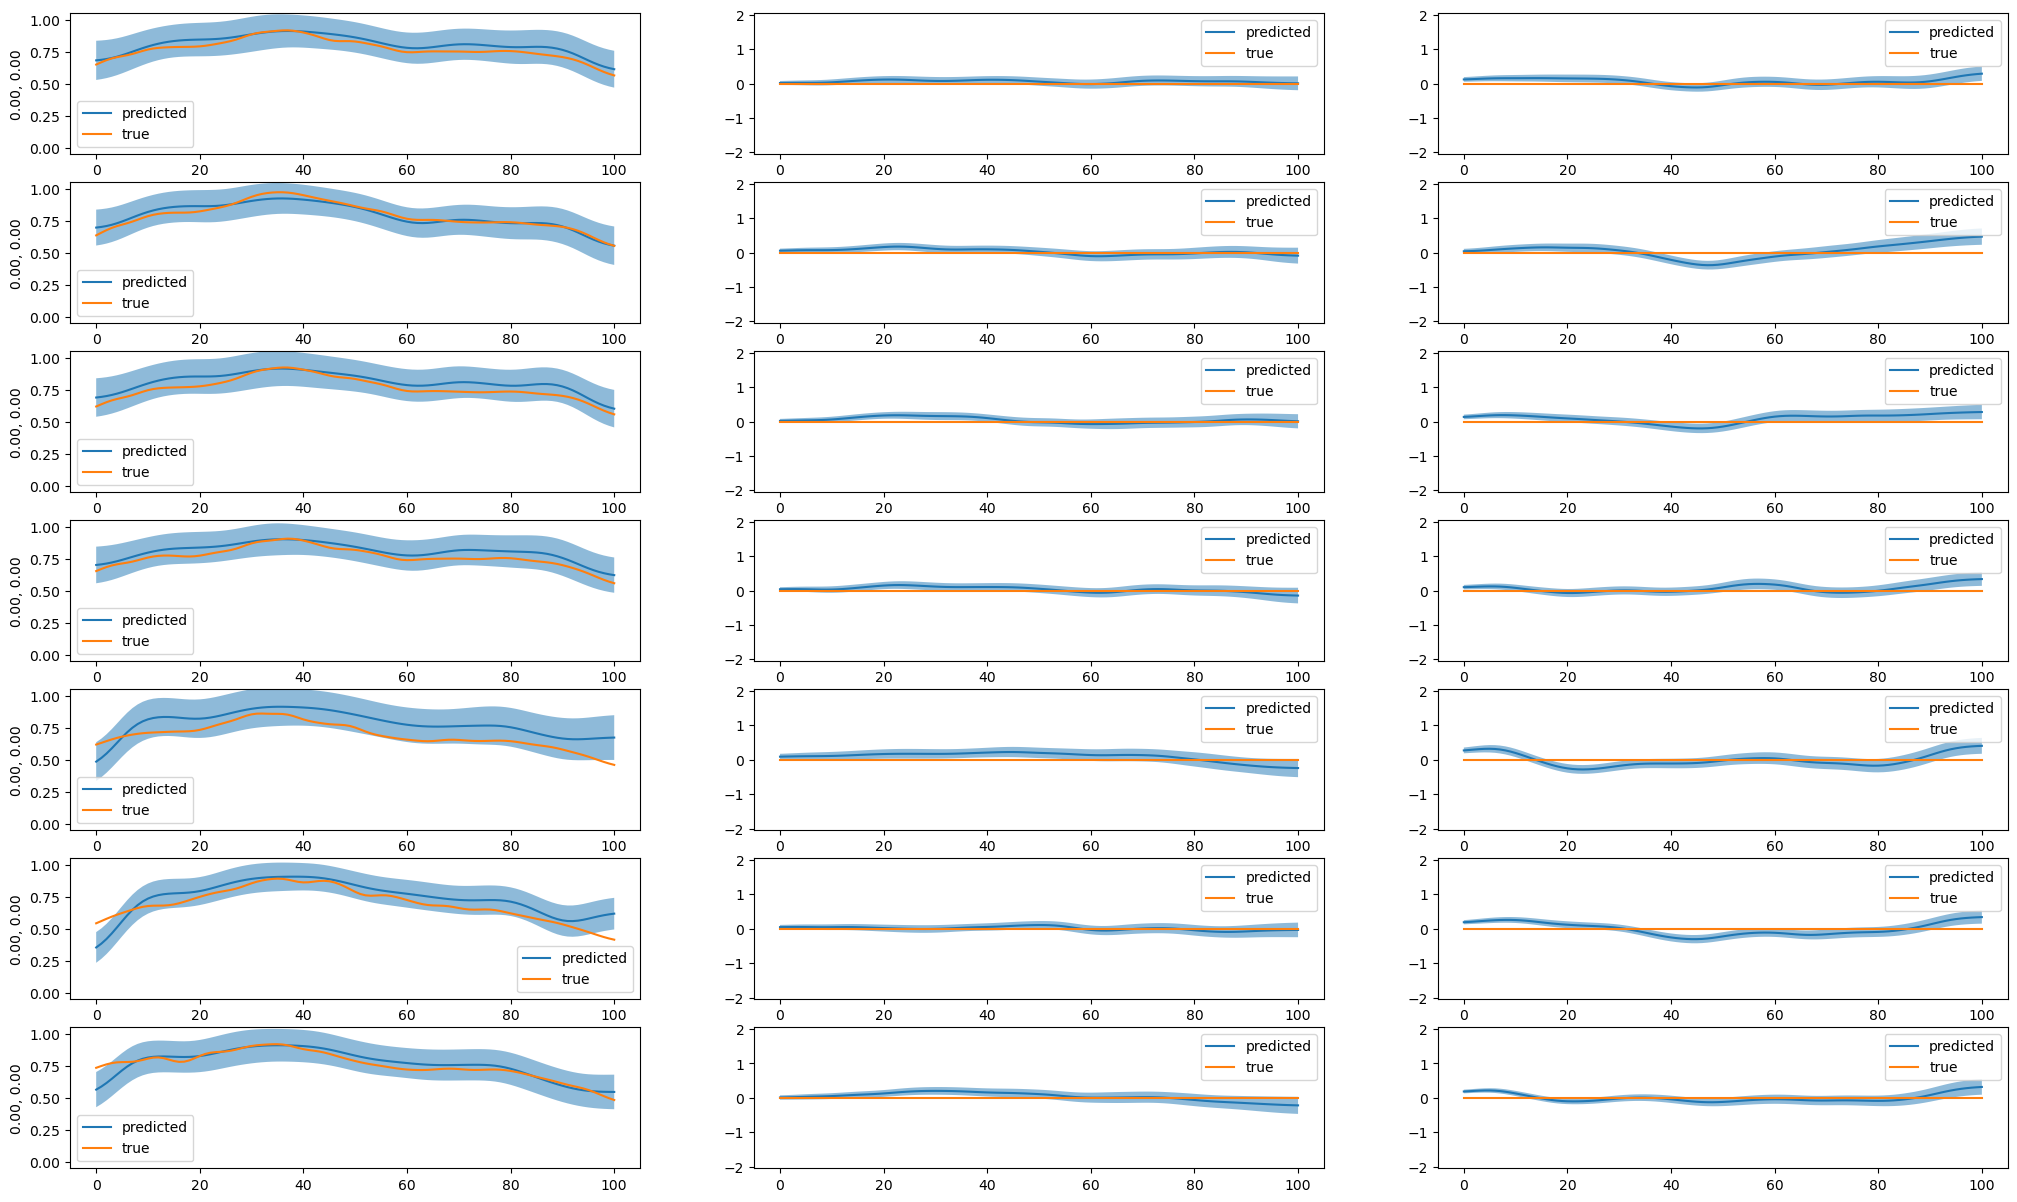

In [26]:
model.eval();

real_pred, real_var = variance_model(x_real_data)

real_pred = real_pred.cpu().detach().numpy()
real_var = real_var.cpu().detach().numpy()
y_real_data = y_real_data.cpu().detach().numpy()

real_pred = np.einsum('ijk,lk->ijl',real_pred,correlation_matrix)
real_var = np.einsum('ijk,lk->ijl',real_var,correlation_matrix)
y_real_data = np.einsum('ijk,lk->ijl',y_real_data,correlation_matrix)

real_std = np.sqrt(real_var)

fig,ax = plt.subplots(7 ,3, figsize = (25,15))

for i in range(7):
    ax[i,0].set_ylabel(f'{x_real_data[i,-2]:.2f}, {x_real_data[i,-1]:.2f}')

    ax[i,0].plot(real_pred[i,0],label='predicted')
    ax[i,0].fill_between(np.arange(len(real_pred[0,0])), real_pred[i,0]-real_std[i,0]  * no_sigma, real_pred[i,0]+real_std[i,0] * no_sigma, alpha = 0.5)
    ax[i,0].plot(y_real_data[i,0],label='true')
    ax[i,0].legend()
    ax[i,0].set_ylim(-.05,1.05)

    ax[i,1].plot(real_pred[i,1],label='predicted')
    ax[i,1].fill_between(np.arange(len(real_pred[0,1])), real_pred[i,1]-real_std[i,1] * no_sigma , real_pred[i,1]+real_std[i,1] * no_sigma, alpha = 0.5)
    ax[i,1].plot(y_real_data[i,1],label='true')
    ax[i,1].legend()
    ax[i,1].set_ylim(-2.05,2.05)


    ax[i,2].plot(real_pred[i,2],label='predicted')
    ax[i,2].fill_between(np.arange(len(real_pred[0,2])), real_pred[i,2]-real_std[i,2]  * no_sigma, real_pred[i,2]+real_std[i,2] * no_sigma, alpha = 0.5)
    ax[i,2].plot(y_real_data[i,2],label='true')
    ax[i,2].legend()
    ax[i,2].set_ylim(-2.05,2.05)



In [27]:
torch.save(variance_model.state_dict(), 'variance_model.pt')